In [14]:
# transformer plus a simple equations: learning physics rules
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F
from simple import WaveFunction

batch_size = 8
block_size = 20
max_iter = 3000
epochs = 9
eval_interval = 500
learning_rate = 1e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embed = 32
n_head = 8
n_layer = 4
dropout = 0.1
text = []

# tokens set as integers
tokens = ['0','1','2','3','4','5','6','7','8','9']

# Example usage with cellular automata
wave_length = 100
step_count = 2

# Let's make some waves! Not strictly needed, but repurposing the wave fn so keeping it for now
c = 1.0  # Wave speed
dx = 0.1  # Spatial step size
dt = 0.1  # Time step size
wave_fn = WaveFunction(c, dx, dt)

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[str(c)] for c in s]
dec = lambda l: ''.join([itos[i] for i in l])
# Define an appropriate size for your validation batch
val_batch_size = batch_size  

# Function to generate a random initial wave profile
def generate_random_wave_profile(size):
    return (np.random.rand(10)*10).astype(int)

# Function to simulate wave sequence
def simulate_wave_sequence(batch_size, size, steps):
    initial_profiles = [generate_random_wave_profile(size) for _ in range(batch_size)]
    final_profiles = []
    for profile in initial_profiles:
        _, final_profile = wave_fn.simulate_wave_equation(profile, steps)
        final_profile_clipped = np.clip(final_profile, 0, 9).astype(int)
        final_profiles.append(final_profile_clipped)
    return initial_profiles, final_profiles

# load data
def get_batch(batch_size, size, steps, block_size):
    initial_profiles, final_profiles = simulate_wave_sequence(batch_size, size, steps)
    # Encoding and decoding logic needs to be updated based on the discretization strategy for wave amplitudes
    X = torch.tensor([enc(s)[:block_size] for s in initial_profiles], dtype=torch.long)
    Y = torch.tensor([enc(s)[:block_size] for s in final_profiles], dtype=torch.long)
    return X.to(device), Y.to(device)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.ReLU(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        attn_output = self.sa(self.ln1(x))
        x = x + attn_output  # add & norm for attention
        ffwd_output = self.ffwd(self.ln2(x))
        x = x + ffwd_output  # add & norm for feedforward
        return x

# bigram language model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1)  # Flatten targets to [batch_size * block_size]
            # targets = targets.view(-1, vocab_size)  # For MSE might need this encording.
            # loss = F.cross_entropy(logits, targets) 
            loss = F.mse_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # loss = F.l1_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx, idx_next), dim = 1)
        return idx
    
model = LanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
loss = None  # Initialize loss variable outside the loop

for epoch in range(epochs):
    for iter in range(max_iter // epochs):  # Distribute iterations across epochs
        model.train()
        xb, yb = get_batch(batch_size, wave_length, step_count, block_size)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if iter % eval_interval == 0 and loss is not None:  # Validation logic
            model.eval()
            with torch.no_grad():
                xv, yv = get_batch(val_batch_size, wave_length, step_count, block_size)
                val_logits, val_loss = model(xv, yv)
                print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
            model.train()

    scheduler.step(val_loss)  # Update the learning rate at the end of each epoch

torch.save(model, '1cat_wave_model.pth')

Epoch 0, Iteration 0: Training Loss = 0.11044427007436752, Validation Loss = 0.10941421240568161
Epoch 1, Iteration 0: Training Loss = 0.03543303906917572, Validation Loss = 0.030978117138147354
Epoch 2, Iteration 0: Training Loss = 0.01548448484390974, Validation Loss = 0.01166684553027153
Epoch 3, Iteration 0: Training Loss = 0.00903796125203371, Validation Loss = 0.006456362083554268
Epoch 4, Iteration 0: Training Loss = 0.0058234441094100475, Validation Loss = 0.0034869113005697727
Epoch 5, Iteration 0: Training Loss = 0.0036032143980264664, Validation Loss = 0.0017709716921672225
Epoch 6, Iteration 0: Training Loss = 0.00250338320620358, Validation Loss = 0.0009651514701545238
Epoch 7, Iteration 0: Training Loss = 0.0019476237939670682, Validation Loss = 0.0003540283069014549
Epoch 8, Iteration 0: Training Loss = 0.0012656876351684332, Validation Loss = 0.00017310501425527036


Decoded Output: 48190813065379950192
Wavefn Output: (array([4, 8, 1, 9, 0, 8, 1, 3, 0, 6]), array([6, 9, 3, 9, 2, 9, 3, 5, 2, 8]))


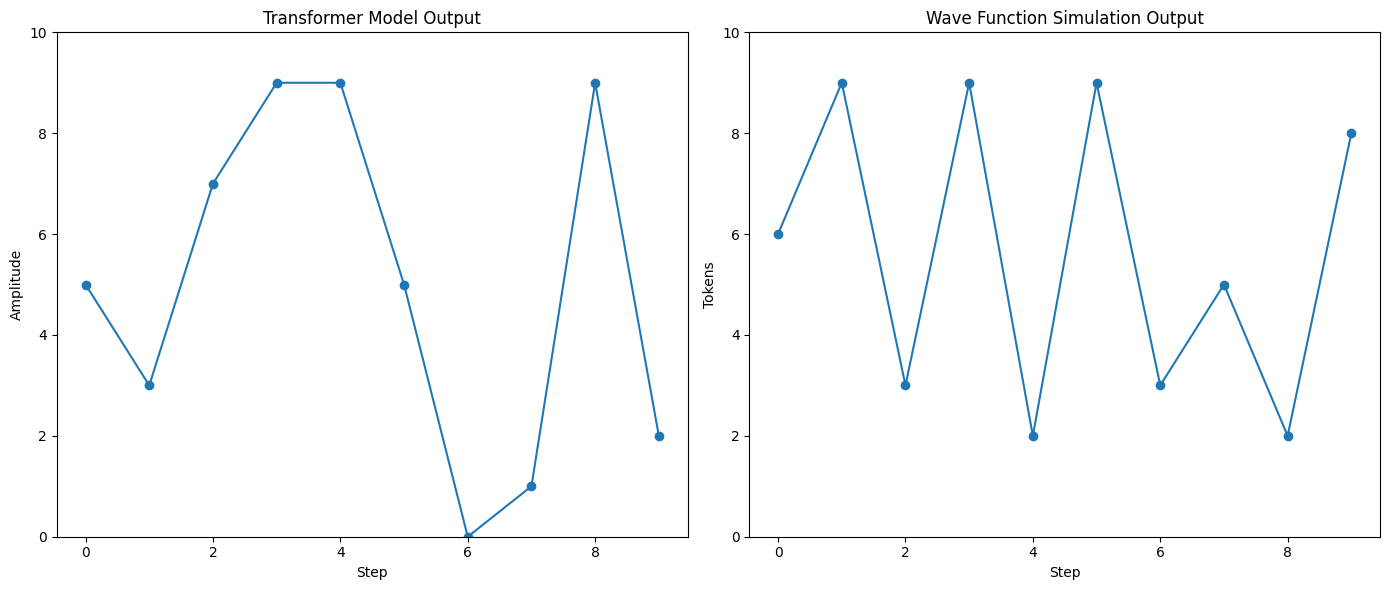

In [20]:
# Load the model
model = torch.load('1cat_wave_model.pth')
model.eval()
# np.random.seed(42)  # Seed for reproducibility
input = (np.random.rand(10)*10).astype(int)
encoded_input = enc(input)

# Convert to a tensor and add a batch dimension (assuming your model expects a batch)
input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)
max_new_tokens = 10  # Define how many new tokens you want to generate
output_tensor = model.generate(input_tensor, max_new_tokens=max_new_tokens)
decoded_output = dec(output_tensor[0].tolist())  # Assuming you're interested in the first item in the batch
sim_wave_output = wave_fn.simulate_wave_equation(input,step_count)
print("Decoded Output:", decoded_output)
print("Wavefn Output:", sim_wave_output)

# Plot!
# Process the decoded output to handle negative numbers correctly
decoded_values = []
i = 0
while i < len(decoded_output):
    if decoded_output[i] == '-':
        # Ensure we capture the negative sign with the number
        decoded_values.append(int(decoded_output[i:i+2]))
        i += 2  # Skip the next character as it's part of the negative number
    else:
        decoded_values.append(int(decoded_output[i]))
        i += 1

decoded_values = np.array(decoded_values)

import matplotlib.pyplot as plt
global_min = min(np.min(decoded_values), np.min(sim_wave_output[1]))
global_max = max(np.max(decoded_values), np.max(sim_wave_output[1]))

plt.figure(figsize=(14, 6))

# Plot for the Transformer Model Output
plt.subplot(1, 2, 1)
plt.plot(decoded_values[10:], marker='o', linestyle='-')
plt.title('Transformer Model Output')
plt.xlabel('Step')
plt.ylabel('Amplitude')
plt.ylim(global_min, global_max+1)  # Set Y-axis limits to be the same for both plots

# Plot for the Wave Function Simulation Output
plt.subplot(1, 2, 2)
plt.plot(sim_wave_output[1], marker='o', linestyle='-')
plt.title('Wave Function Simulation Output')
plt.xlabel('Step')
plt.ylabel('Tokens')
plt.ylim(global_min, global_max+1)  # Set Y-axis limits to be the same for both plots

plt.tight_layout()
plt.show()
